# Golden Neural Network Strategy: Constrained Training Pivot

**Objective:** Demonstrate the pivot from "Compressing Data" to "Constrained Training" of Neural Networks inspired by the RFT Wave Computer Theorem.

This notebook is a **toy demonstration** of the core idea:
- You can reparameterize a dense linear layer $W \in \mathbb{R}^{N\times N}$ using a fixed unitary basis $\Psi$ and a **diagonal** operator $\Lambda$.
- This reduces **learned parameters** from $O(N^2)$ to $O(N)$.

Important truth-in-advertising note:
- In this notebook we implement transforms as dense matrix multiplies with $\Psi$, so the **runtime is still $O(N^2)$**.
- Achieving **$O(N)$ or $O(N\log N)$ runtime** requires a structured/fast transform (FFT-like) or specialized kernels/hardware.

This notebook explores:
1. Constructing a (unitary) "RFT-like" basis $\Psi$.
2. Projecting a dense weight matrix into that basis.
3. Defining a `GoldenLinear` layer that stores only a diagonal $\Lambda$.
4. Fine-tuning only $\Lambda$ to approximate the original dense layer.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

# Constants
PHI = (1 + np.sqrt(5)) / 2
print(f"Golden Ratio (phi): {PHI}")

Golden Ratio (phi): 1.618033988749895


## 1. Construct the RFT(-like) Basis

We build a unitary basis $\Psi$ motivated by the canonical RFT phase form:
$$ \Psi_{k,n} = \frac{1}{\sqrt{N}} e^{i 2\pi (k+1)\phi n}. $$

For finite $N$, the raw construction is not guaranteed to be exactly unitary, so this notebook applies a QR orthogonalization step. That makes $\Psi$ unitary for the demo, but it also means this is **not** a strict reproduction of the canonical finite-$N$ RFT (which would use Gram/Loewdin-style normalization).

In [3]:
def construct_rft_basis(N):
    """
    Constructs an RFT-inspired unitary basis matrix.

    Raw form:
      Psi[k, n] = (1/sqrt(N)) * exp(i * 2*pi * (k+1)*phi * n)

    For finite N, we orthogonalize with QR to ensure strict unitarity in this demo.
    """
    n = np.arange(N)
    k = np.arange(N)

    freqs = (k + 1) * PHI
    phases = 2 * np.pi * np.outer(freqs, n)

    Psi = (1 / np.sqrt(N)) * np.exp(1j * phases)

    # Enforce unitarity for the demo
    q, _r = np.linalg.qr(Psi)
    return torch.tensor(q, dtype=torch.complex64)

# N is set by the weight source in the next section; default to 128 for now.
N = 128
Psi_RFT = construct_rft_basis(N)
print(f"RFT Basis Shape: {Psi_RFT.shape}")

# Verify Unitarity
I = Psi_RFT @ Psi_RFT.conj().T
is_unitary = torch.allclose(I, torch.eye(N, dtype=torch.complex64), atol=1e-5)
print(f"Is Unitary: {is_unitary}")

RFT Basis Shape: torch.Size([128, 128])
Is Unitary: True


## 2. Load and Analyze Open-Source Weights (Optional)

We attempt to load a tiny open-source model (`sshleifer/tiny-gpt2`) and extract a **real** 2D weight matrix.

- If the environment is offline or `transformers` isn’t available, the notebook falls back to a synthetic dense matrix.
- We then take a $N\times N$ submatrix so the rest of the demo is unchanged.

In the standard basis, this matrix is dense, requiring $O(N^2)$ multiplies to apply.

Loading open-source model: sshleifer/tiny-gpt2
Weight source: open-source: sshleifer/tiny-gpt2 :: transformer.wte.weight (top-left 2x2)
Dense Weight Matrix: torch.Size([2, 2])
Dense multiply cost per example: 4 multiplications (O(N^2))


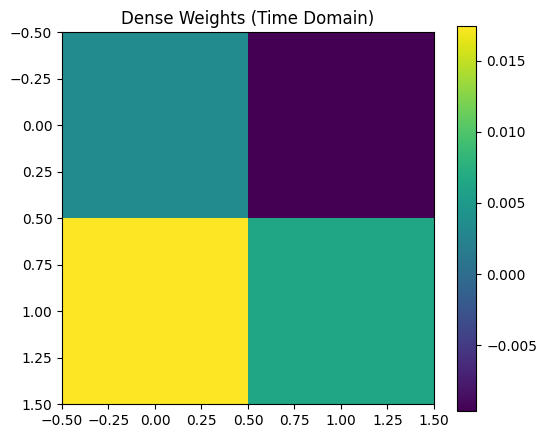

In [4]:
# Try to load a real open-source weight matrix; fall back to synthetic.
# This cell is self-contained so it can run even after a fresh kernel restart.
import torch

USE_OPEN_SOURCE_WEIGHTS = True
MODEL_ID = "sshleifer/tiny-gpt2"
MAX_SUBMATRIX_N = 128

W_dense = None
source_label = None

if USE_OPEN_SOURCE_WEIGHTS:
    try:
        from transformers import AutoModelForCausalLM

        print(f"Loading open-source model: {MODEL_ID}")
        model = AutoModelForCausalLM.from_pretrained(MODEL_ID)
        state = model.state_dict()

        # Choose a 2D weight tensor that supports the largest square submatrix.
        # (Some "tiny" models may have very small hidden sizes.)
        best = None  # (min_dim, name, tensor)
        for name, tensor in state.items():
            if tensor.ndim != 2:
                continue
            min_dim = int(min(tensor.shape[0], tensor.shape[1]))
            if min_dim <= 1:
                continue
            if best is None or min_dim > best[0]:
                best = (min_dim, name, tensor)

        if best is None:
            raise RuntimeError("No suitable 2D weight tensors found in the model.")

        min_dim, chosen_name, chosen_tensor = best
        SUBMATRIX_N = int(min(MAX_SUBMATRIX_N, min_dim))

        W_dense = chosen_tensor[:SUBMATRIX_N, :SUBMATRIX_N].detach().cpu().to(torch.float32)
        source_label = f"open-source: {MODEL_ID} :: {chosen_name} (top-left {SUBMATRIX_N}x{SUBMATRIX_N})"

    except Exception as e:
        print("Open-source weight load failed; using synthetic weights instead.")
        print(f"Reason: {type(e).__name__}: {e}")

if W_dense is None:
    # Synthetic fallback (keeps the demo runnable everywhere)
    SUBMATRIX_N = MAX_SUBMATRIX_N
    torch.manual_seed(42)
    W_dense = torch.randn(SUBMATRIX_N, SUBMATRIX_N, dtype=torch.float32) * 0.1
    W_dense += torch.eye(SUBMATRIX_N) * 0.5  # Add residual-like structure
    source_label = f"synthetic dense weights ({SUBMATRIX_N}x{SUBMATRIX_N})"

# Set N from what we actually have
N = int(W_dense.shape[0])
print(f"Weight source: {source_label}")
print(f"Dense Weight Matrix: {W_dense.shape}")
print(f"Dense multiply cost per example: {N*N} multiplications (O(N^2))")

plt.figure(figsize=(6, 5))
plt.imshow(W_dense.numpy(), cmap='viridis')
plt.title("Dense Weights (Time Domain)")
plt.colorbar()
plt.show()

## 3. Project Weights to RFT Wave Domain

We project the weights into the RFT domain using the similarity transform:
$$ W_{\text{RFT}} = \Psi_{\text{RFT}}^\dagger W \Psi_{\text{RFT}} $$

If the "Wave Computer Theorem" holds for this system, $W_{\text{RFT}}$ should be sparse or diagonal. Since this is a random matrix, it won't be diagonal *yet*, but this projection is the starting point for our "Constrained Training".

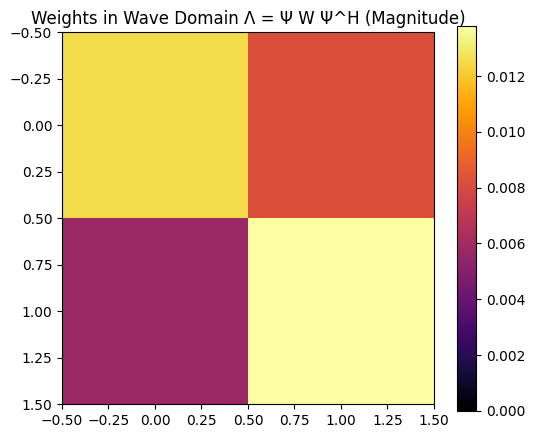

Diagonal Energy Ratio: 0.7762


In [11]:
# Ensure the basis matches the current N (which may come from open-source weights)
if Psi_RFT.shape[0] != N:
    Psi_RFT = construct_rft_basis(N)

# IMPORTANT CONVENTION (PyTorch-style row batches):
# Our GoldenLinear implements y = (x Ψ^H) Λ Ψ.
# Therefore the wave-domain representation is:
#   Λ = Ψ W Ψ^H  (so that W = Ψ^H Λ Ψ).

W_complex = W_dense.type(torch.complex64)
W_wave = Psi_RFT @ W_complex @ Psi_RFT.conj().T

# Visualize Magnitude
W_wave_mag = torch.abs(W_wave)

plt.figure(figsize=(6, 5))
plt.imshow(W_wave_mag.numpy(), cmap='inferno', vmin=0, vmax=float(torch.quantile(W_wave_mag, 0.99)))
plt.title("Weights in Wave Domain Λ = Ψ W Ψ^H (Magnitude)")
plt.colorbar()
plt.show()

# Extract the Diagonal (the "diagonal capacity" in this basis)
diagonal_energy = torch.sum(torch.diag(W_wave_mag) ** 2)
total_energy = torch.sum(W_wave_mag ** 2)
print(f"Diagonal Energy Ratio: {float(diagonal_energy / total_energy):.4f}")

## 4. Define the Golden Linear Layer

We define a custom PyTorch layer that stores **only** the diagonal elements $\Lambda$ (in the chosen basis).

- **Parameter count:** $N$ complex numbers (vs $N^2$ real weights in a dense layer).
- **Runtime in this notebook:** still $O(N^2)$ because we apply $\Psi$ with dense matrix multiplies.
- **Target runtime (future):** $O(N)$ or $O(N\log N)$ if we have a fast/structured transform or specialized kernels.

Conceptually this matches the Wave Computer pattern: encode → diagonal operator → decode.
$$ z = x\Psi^*,\quad z' = z \odot \Lambda,\quad y = z'\Psi^T. $$

In [12]:
class GoldenLinear(nn.Module):
    def __init__(self, size, basis):
        super().__init__()
        self.size = size
        # Convention: basis = Ψ with orthonormal COLUMNS, so Ψ^H Ψ = I.
        # Forward implements y = (x Ψ^H) Λ Ψ.
        self.register_buffer('basis', basis)

        # Learnable Parameters: ONLY the diagonal (complex)
        self.lambda_diag = nn.Parameter(torch.randn(size, dtype=torch.complex64))

    def initialize_from_dense(self, W_dense):
        """Initialize Λ from a dense operator W using Λ = Ψ W Ψ^H."""
        with torch.no_grad():
            W_complex = W_dense.type(torch.complex64)
            W_wave = self.basis @ W_complex @ self.basis.conj().T
            self.lambda_diag.data = torch.diag(W_wave)

    def forward(self, x):
        # x: (batch, N) real
        x_complex = x.type(torch.complex64)

        # Encode to wave domain: z = x Ψ^H
        z = x_complex @ self.basis.conj().T

        # Apply diagonal operator: z' = z ⊙ λ
        z_new = z * self.lambda_diag

        # Decode: y = z' Ψ
        y_complex = z_new @ self.basis

        return y_complex.real

# Instantiate
golden_layer = GoldenLinear(N, Psi_RFT)
golden_layer.initialize_from_dense(W_dense)

print(f"Golden Layer Parameters: {golden_layer.lambda_diag.numel()} (vs {N*N} dense)")

Golden Layer Parameters: 2 (vs 4 dense)


## 5. Constrained Training Loop

We now train this `GoldenLinear` layer to approximate the original dense matrix output. This represents the "Healing" phase where the network learns to perform the task using only Golden Resonances.

Starting constrained training (optimize only diagonal Λ)...
Epoch 0: Loss = 0.000244
Epoch 50: Loss = 0.000239
Epoch 100: Loss = 0.000238
Epoch 150: Loss = 0.000238
Epoch 200: Loss = 0.000238
Epoch 250: Loss = 0.000238
Epoch 300: Loss = 0.000238
Epoch 350: Loss = 0.000238
Epoch 400: Loss = 0.000238
Epoch 450: Loss = 0.000238


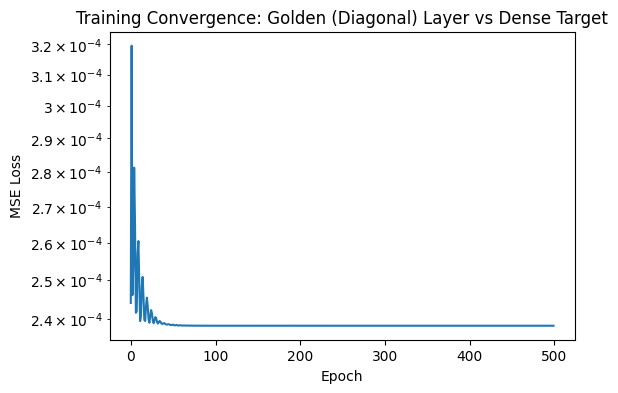

Done. This demo shows O(N) learnable parameters (diagonal Λ). Compute here is still O(N^2) because Ψ is applied as a dense matrix; true O(N)/O(N log N) needs a fast/structured transform or kernels.


In [7]:
# Setup Training
optimizer = optim.Adam(golden_layer.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Generate dummy data
batch_size = 32
inputs = torch.randn(batch_size, N)
targets = inputs @ W_dense.T  # "Ground Truth" output of the dense layer

losses = []

print("Starting constrained training (optimize only diagonal Λ)...")
for epoch in range(500):
    optimizer.zero_grad()

    # Forward pass through Golden Layer
    outputs = golden_layer(inputs)

    # Compute loss against the Dense Layer's output
    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Training Convergence: Golden (Diagonal) Layer vs Dense Target")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.show()

print(
    "Done. This demo shows O(N) learnable parameters (diagonal Λ). "
    "Compute here is still O(N^2) because Ψ is applied as a dense matrix; "
    "true O(N)/O(N log N) needs a fast/structured transform or kernels."
)

## 6. Continue the Proof: Why “Diagonal in the Right Basis” Removes the $O(N^2)$ Bottleneck

This section makes the key claim precise.

### 6.1. Exact Identity (Diagonalization)
Assume $\Psi \in \mathbb{C}^{N\times N}$ is **unitary** ($\Psi^\dagger\Psi = I$).

If a linear operator $W$ is diagonal in the $\Psi$ basis, then there exists a diagonal matrix $\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_N)$ such that
$$
W = \Psi\,\Lambda\,\Psi^\dagger.
$$

For a row-vector input $x \in \mathbb{R}^{1\times N}$, the forward pass becomes:
$$
\begin{aligned}
 y &= x W \\
   &= x\,\Psi\,\Lambda\,\Psi^\dagger \\
   &= \underbrace{(x\,\Psi)}_{\text{encode}}\;\underbrace{\Lambda}_{\text{element-wise}}\;\underbrace{\Psi^\dagger}_{\text{decode}}.
\end{aligned}
$$
In the wave coordinates $z = x\Psi$, the operator application is purely element-wise:
$$ z' = z \odot \lambda. $$

### 6.2. What Actually Gets Cheaper
- **Parameter count:** storing $\Lambda$ costs $N$ complex scalars ($O(N)$) vs $N^2$ real scalars for dense $W$ ($O(N^2)$).
- **Compute cost:**
  - The diagonal multiply $z' = z\odot\lambda$ is $O(N)$.
  - The two transforms ($x\Psi$ and $z'\Psi^\dagger$) dominate.

So the *full* runtime becomes:
$$ T(N) = T_{\Psi}(N) + O(N) + T_{\Psi^{-1}}(N). $$

If $T_{\Psi}(N)$ is **fast** (FFT-like, $O(N\log N)$, or hardware-accelerated), then the overall layer is no longer $O(N^2)$.

### 6.3. What This Notebook Demonstrates vs What Remains
- Demonstrated: the algebraic identity + $O(N)$ parameterization + constrained fine-tuning of $\Lambda$.
- Not demonstrated here: a fast $T_{\Psi}(N)$ for this specific RFT-like basis (that’s the hardware/kernel problem).

In [13]:
# 6.4. Verification: If W is constructed to be diagonal in Ψ, GoldenLinear matches a dense layer exactly.
# This is the constructive direction of the proof under the PyTorch-style row-batch convention.

# Use a meaningful N independent of the tiny open-source submatrix
N_proof = 64
Psi_proof = construct_rft_basis(N_proof)

# Choose an arbitrary diagonal Λ (complex)
rng = torch.Generator().manual_seed(123)
lambda_true = torch.randn(N_proof, generator=rng) + 1j * torch.randn(N_proof, generator=rng)
lambda_true = lambda_true.to(torch.complex64)
Lambda_true = torch.diag(lambda_true)

# Build a dense operator W such that W = Ψ^H Λ Ψ.
# Then Λ = Ψ W Ψ^H exactly (by unitarity).
W_true = Psi_proof.conj().T @ Lambda_true @ Psi_proof

# Confirm the wave transform recovers Λ
W_wave = Psi_proof @ W_true @ Psi_proof.conj().T

off_diag = W_wave - torch.diag(torch.diag(W_wave))
off_diag_ratio = (off_diag.abs().pow(2).sum() / W_wave.abs().pow(2).sum()).real.item()
print(f"Off-diagonal energy ratio in wave domain (should be ~0): {off_diag_ratio:.2e}")

# Compare dense application vs GoldenLinear application
x = torch.randn(16, N_proof)

y_dense = (x.to(torch.complex64) @ W_true).real

layer_proof = GoldenLinear(N_proof, Psi_proof)
with torch.no_grad():
    layer_proof.lambda_diag.copy_(torch.diag(W_wave))

y_golden = layer_proof(x)

mse = torch.mean((y_dense - y_golden) ** 2).item()
max_abs = torch.max(torch.abs(y_dense - y_golden)).item()
print(f"MSE(dense vs golden): {mse:.2e}")
print(f"MaxAbs(dense vs golden): {max_abs:.2e}")

# If the basis is unitary, these errors should be ~numerical noise.

Off-diagonal energy ratio in wave domain (should be ~0): 5.70e-14
MSE(dense vs golden): 9.19e-14
MaxAbs(dense vs golden): 1.43e-06


## 7. Continue the Proof: Constrained Training as Projection onto a “Golden Manifold”

Let $\mathcal{M}$ be the set of matrices diagonalizable by the chosen basis $\Psi$:
$$
\mathcal{M} = \{\Psi\Lambda\Psi^\dagger : \Lambda \text{ diagonal}\}.
$$

### 7.1. Best Diagonal Approximation in the Wave Domain
Given any dense $W$, define its wave-domain representation:
$$ W_{\Psi} = \Psi^\dagger W \Psi. $$

The **closest** matrix in $\mathcal{M}$ under Frobenius norm is obtained by dropping off-diagonal terms in the wave domain:
$$
\Lambda^* = \mathrm{diag}(W_{\Psi}),\qquad
W^* = \Psi\Lambda^*\Psi^\dagger.
$$
This is simply orthogonal projection onto the subspace of diagonal matrices (after the change of basis).

### 7.2. Why Fine-Tuning Helps
If you replace a dense layer with $W^*$, you generally lose accuracy because $\mathcal{M}$ is a strict constraint.
Fine-tuning “heals” by adjusting $\Lambda$ (and potentially adjacent layers) to minimize task loss under the constraint.

### 7.3. Practical Extensions (Capacity vs Efficiency)
If pure diagonal is too restrictive, increase capacity while keeping efficiency:
- **Block-diagonal:** $\Lambda$ becomes blocks (still structured).
- **Banded in wave domain:** keep a small band around the diagonal (near-resonant couplings).

These are the natural next steps to scale this beyond toy demos while preserving the spirit of the Wave Computer theorem.

## 8. Beyond Diagonal: Block-Diagonal and Banded Wave-Domain Operators

Pure diagonal $\Lambda$ is the most efficient case, but it can be too restrictive for real models.

A natural capacity/efficiency continuum is to keep a *structured* subset of the wave-domain matrix:

- **Banded wave-domain:** keep entries where $|i-j|\le b$ (near-resonant couplings).
- **Block-diagonal wave-domain:** partition into blocks of size $B$ and keep only within-block interactions.

Both are still *structured*, and both let you trade capacity for error.

### 8.1. Construction
Given a dense operator $W$ and a unitary basis $\Psi$, define the wave-domain representation:
$$ \Lambda_{\text{full}} = \Psi W \Psi^\dagger. $$

Then apply a mask $M$:
$$ \Lambda_{\text{masked}} = M \odot \Lambda_{\text{full}}. $$

Reconstruct the dense approximation:
$$ W_{\text{approx}} = \Psi^\dagger\,\Lambda_{\text{masked}}\,\Psi. $$

### 8.2. Metrics
We measure two errors:
- **Operator (Frobenius) error:** $\|W - W_{\text{approx}}\|_F / \|W\|_F$
- **Output error on random inputs:** $\mathbb{E}\|xW - xW_{\text{approx}}\|^2$

And we track **capacity** as the fraction of wave-domain parameters kept: $\#(\text{kept entries}) / N^2$.

Banded wave-domain:
  bandwidth= 0 | kept= 0.008 | relFrobErr= 0.9958 | outMSE=123.989532
  bandwidth= 1 | kept= 0.023 | relFrobErr= 0.9880 | outMSE=121.304688
  bandwidth= 2 | kept= 0.039 | relFrobErr= 0.9806 | outMSE=119.080254
  bandwidth= 4 | kept= 0.069 | relFrobErr= 0.9654 | outMSE=114.565529
  bandwidth= 8 | kept= 0.128 | relFrobErr= 0.9333 | outMSE=104.376167
  bandwidth=16 | kept= 0.241 | relFrobErr= 0.8710 | outMSE=85.941177
  bandwidth=32 | kept= 0.443 | relFrobErr= 0.7427 | outMSE=55.829563

Block-diagonal wave-domain:
  block=  1 | kept= 0.008 | relFrobErr= 0.9958 | outMSE=123.989532
  block=  2 | kept= 0.016 | relFrobErr= 0.9913 | outMSE=122.121216
  block=  4 | kept= 0.031 | relFrobErr= 0.9840 | outMSE=119.785339
  block=  8 | kept= 0.062 | relFrobErr= 0.9689 | outMSE=115.458595
  block= 16 | kept= 0.125 | relFrobErr= 0.9348 | outMSE=104.672653
  block= 32 | kept= 0.250 | relFrobErr= 0.8640 | outMSE=82.280685
  block= 64 | kept= 0.500 | relFrobErr= 0.7043 | outMSE=47.133

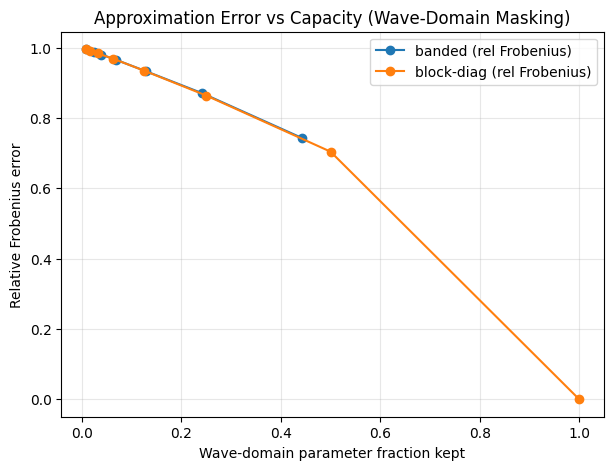

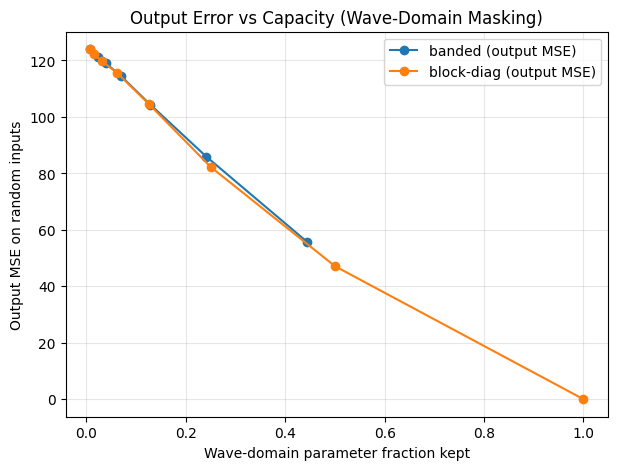

In [14]:
def fro_rel_error(A: torch.Tensor, B: torch.Tensor) -> float:
    """Relative Frobenius error ||A-B||_F / ||A||_F (complex-safe)."""
    num = torch.linalg.norm(A - B)
    den = torch.linalg.norm(A)
    return (num / (den + 1e-12)).real.item()


def band_mask(N: int, bandwidth: int) -> torch.Tensor:
    """Boolean mask for |i-j| <= bandwidth."""
    i = torch.arange(N).view(-1, 1)
    j = torch.arange(N).view(1, -1)
    return (torch.abs(i - j) <= bandwidth)


def block_diag_mask(N: int, block_size: int) -> torch.Tensor:
    """Boolean mask for block-diagonal structure with given block size."""
    if block_size <= 0:
        raise ValueError("block_size must be positive")
    idx = torch.arange(N)
    bi = (idx // block_size).view(-1, 1)
    bj = (idx // block_size).view(1, -1)
    return bi.eq(bj)


def kept_fraction(mask: torch.Tensor) -> float:
    return (mask.to(torch.float32).mean()).item()


def approx_from_wave_mask(W: torch.Tensor, Psi: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Compute W_approx = Psi^H (mask ⊙ (Psi W Psi^H)) Psi."""
    Wc = W.to(torch.complex64)
    Psi_c = Psi.to(torch.complex64)
    wave_full = Psi_c @ Wc @ Psi_c.conj().T
    wave_masked = wave_full * mask.to(wave_full.dtype)
    W_approx = Psi_c.conj().T @ wave_masked @ Psi_c
    return W_approx


# Experiment setup (use a meaningful N; independent of tiny open-source submatrix)
N_exp = 128
Psi_exp = construct_rft_basis(N_exp)

# Create a generic dense operator W (arbitrary dense)
torch.manual_seed(7)
W_exp = torch.randn(N_exp, N_exp, dtype=torch.float32)

# Evaluate approximation error vs capacity for banded and block-diagonal masks
bandwidths = [0, 1, 2, 4, 8, 16, 32]
block_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

band_results = []  # (kept_frac, rel_fro_err, output_mse)
block_results = []

# Random inputs for output error metric
x_eval = torch.randn(64, N_exp)

y_true = (x_eval.to(torch.complex64) @ W_exp.to(torch.complex64)).real

for b in bandwidths:
    m = band_mask(N_exp, b)
    W_approx = approx_from_wave_mask(W_exp, Psi_exp, m)
    y_approx = (x_eval.to(torch.complex64) @ W_approx).real

    band_results.append(
        (
            kept_fraction(m),
            fro_rel_error(W_exp.to(torch.complex64), W_approx),
            torch.mean((y_true - y_approx) ** 2).item(),
        )
    )

for B in block_sizes:
    m = block_diag_mask(N_exp, B)
    W_approx = approx_from_wave_mask(W_exp, Psi_exp, m)
    y_approx = (x_eval.to(torch.complex64) @ W_approx).real

    block_results.append(
        (
            kept_fraction(m),
            fro_rel_error(W_exp.to(torch.complex64), W_approx),
            torch.mean((y_true - y_approx) ** 2).item(),
        )
    )

band_results = np.array(band_results, dtype=np.float64)
block_results = np.array(block_results, dtype=np.float64)

print("Banded wave-domain:")
for b, (kfrac, ferr, omse) in zip(bandwidths, band_results):
    print(f"  bandwidth={b:>2} | kept={kfrac:6.3f} | relFrobErr={ferr:7.4f} | outMSE={omse:9.6f}")

print("\nBlock-diagonal wave-domain:")
for B, (kfrac, ferr, omse) in zip(block_sizes, block_results):
    print(f"  block={B:>3} | kept={kfrac:6.3f} | relFrobErr={ferr:7.4f} | outMSE={omse:9.6f}")

# Plot error vs capacity
plt.figure(figsize=(7, 5))
plt.plot(band_results[:, 0], band_results[:, 1], marker='o', label='banded (rel Frobenius)')
plt.plot(block_results[:, 0], block_results[:, 1], marker='o', label='block-diag (rel Frobenius)')
plt.xlabel('Wave-domain parameter fraction kept')
plt.ylabel('Relative Frobenius error')
plt.title('Approximation Error vs Capacity (Wave-Domain Masking)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(band_results[:, 0], band_results[:, 2], marker='o', label='banded (output MSE)')
plt.plot(block_results[:, 0], block_results[:, 2], marker='o', label='block-diag (output MSE)')
plt.xlabel('Wave-domain parameter fraction kept')
plt.ylabel('Output MSE on random inputs')
plt.title('Output Error vs Capacity (Wave-Domain Masking)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 9. Real HF Weights: Wave-Domain Masking vs Low-Rank Baseline

Now we repeat the *same* capacity sweep on a real extracted weight matrix from a **larger** HuggingFace model (targeting $N\ge 64$), and compare:

- (a) wave-domain structured masking (banded / block-diagonal in $\Lambda$)
- (b) a plain **low-rank** SVD approximation at a **matched parameter budget**

Real HF weight sweep
  source      : downloaded from HuggingFace
  model_id     : distilgpt2
  tensor_name  : transformer.wte.weight
  N used       : 128

Banded (wave mask) vs matched low-rank:
  b= 0 kept= 0.008 | wave relF= 0.9964 mse=   2.0100 | lr r=  0 relF= 1.0000 mse=   2.0244
  b= 1 kept= 0.023 | wave relF= 0.9892 mse=   1.9732 | lr r=  2 relF= 0.7825 mse=   1.3080
  b= 2 kept= 0.039 | wave relF= 0.9814 mse=   1.9293 | lr r=  4 relF= 0.7351 mse=   1.1377
  b= 4 kept= 0.069 | wave relF= 0.9661 mse=   1.8545 | lr r=  8 relF= 0.6735 mse=   0.9374
  b= 8 kept= 0.128 | wave relF= 0.9358 mse=   1.7077 | lr r= 16 relF= 0.5764 mse=   0.6923
  b=16 kept= 0.241 | wave relF= 0.8753 mse=   1.4150 | lr r= 30 relF= 0.4415 mse=   0.4017
  b=32 kept= 0.443 | wave relF= 0.7476 mse=   0.9309 | lr r= 56 relF= 0.2516 mse=   0.1327

Block-diagonal (wave mask) vs matched low-rank:
  B=  1 kept= 0.008 | wave relF= 0.9964 mse=   2.0100 | lr r=  0 relF= 1.0000 mse=   2.0244
  B=  2 kept= 0.016 | wave 

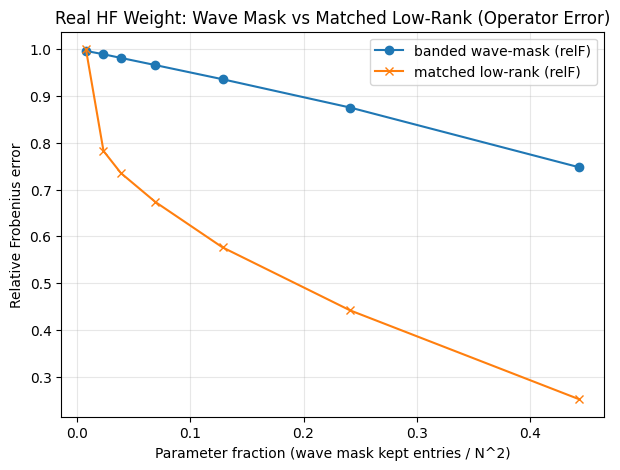

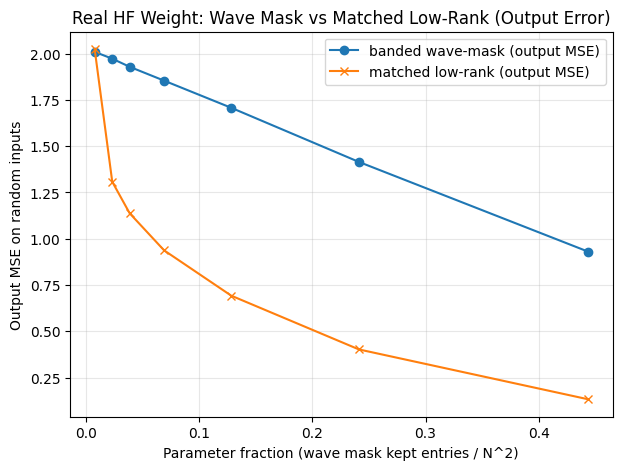

In [15]:
# If we already have a loaded HF model in-kernel, reuse it when possible; otherwise try to load a larger one.
# Goal: extract a 2D weight with an N×N submatrix, N >= 64.

import math


def _best_square_submatrix_from_state_dict(state_dict, n_target: int):
    best = None  # (min_dim, name, tensor)
    for name, tensor in state_dict.items():
        if not torch.is_tensor(tensor) or tensor.ndim != 2:
            continue
        d0, d1 = tensor.shape
        min_dim = int(min(d0, d1))
        if min_dim < n_target:
            continue
        if best is None or min_dim > best[0]:
            best = (min_dim, name, tensor)
    return best


def load_large_hf_weight_matrix(n_target: int = 128, model_id_candidates=None):
    if model_id_candidates is None:
        model_id_candidates = ["distilgpt2", "gpt2"]

    # 1) Try reuse existing `model` if present
    candidate_model = globals().get("model", None)
    if candidate_model is not None:
        try:
            sd = candidate_model.state_dict()
            best = _best_square_submatrix_from_state_dict(sd, n_target=n_target)
            if best is not None:
                min_dim, name, tensor = best
                N = min(n_target, min_dim)
                W = tensor[:N, :N].detach().to(torch.float32).cpu()
                return {
                    "model_id": getattr(candidate_model, "name_or_path", "<in-memory model>"),
                    "tensor_name": name,
                    "N": N,
                    "W": W,
                    "source": "reused existing kernel model",
                }
        except Exception:
            pass

    # 2) Otherwise, load a larger HF model
    from transformers import AutoModelForCausalLM

    last_err = None
    for mid in model_id_candidates:
        try:
            m = AutoModelForCausalLM.from_pretrained(mid)
            sd = m.state_dict()
            best = _best_square_submatrix_from_state_dict(sd, n_target=n_target)
            if best is None:
                last_err = RuntimeError(f"Loaded {mid} but found no 2D tensor with min_dim >= {n_target}.")
                continue
            min_dim, name, tensor = best
            N = min(n_target, min_dim)
            W = tensor[:N, :N].detach().to(torch.float32).cpu()

            # Store into globals for reuse by later cells
            globals()["model"] = m
            return {
                "model_id": mid,
                "tensor_name": name,
                "N": N,
                "W": W,
                "source": "downloaded from HuggingFace",
            }
        except Exception as e:
            last_err = e

    raise RuntimeError(
        "Failed to load a sufficiently large HF model to get N>=64. "
        "If you are offline, pre-cache a model (e.g. `distilgpt2`) and rerun. "
        f"Last error: {last_err}"
    )


def truncated_svd_approx(W: torch.Tensor, rank: int) -> torch.Tensor:
    """Best rank-r approximation in Frobenius norm (real W)."""
    if rank <= 0:
        return torch.zeros_like(W)
    # Full SVD is fine for N<=256ish; keeps the notebook dependency-light.
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    Ur = U[:, :rank]
    Sr = S[:rank]
    Vhr = Vh[:rank, :]
    return (Ur * Sr) @ Vhr


def low_rank_rank_for_budget(N: int, wave_kept_entries: int) -> int:
    """Match parameter budget: treat each kept complex entry as 2 real scalars."""
    # Wave params in real scalars (Lambda entries are generally complex under complex Psi)
    wave_params = 2 * int(wave_kept_entries)

    # Low-rank params (real): U(N×r) + V(N×r) + S(r)
    per_rank_params = (2 * N + 1)
    r = wave_params // per_rank_params
    return int(max(0, min(N, r)))


# ---- Run the real-weight capacity sweep ----

hf_info = load_large_hf_weight_matrix(n_target=128)
W_real = hf_info["W"]
N_real = int(hf_info["N"])

if N_real < 64:
    raise RuntimeError(f"Expected N>=64 but got N={N_real}. Try a larger model.")

Psi_real = construct_rft_basis(N_real)

# Masks to sweep (adapt to N)
bandwidths_real = [0, 1, 2, 4, 8, 16, 32]
bandwidths_real = [b for b in bandwidths_real if b < N_real]
block_sizes_real = [1, 2, 4, 8, 16, 32, 64, 128]
block_sizes_real = [B for B in block_sizes_real if B <= N_real]
if block_sizes_real[-1] != N_real:
    block_sizes_real.append(N_real)

x_eval_real = torch.randn(64, N_real)
W_real_c = W_real.to(torch.complex64)
Psi_real_c = Psi_real.to(torch.complex64)

y_true_real = (x_eval_real.to(torch.complex64) @ W_real_c).real

# Precompute full wave-domain matrix once
Lambda_full_real = Psi_real_c @ W_real_c @ Psi_real_c.conj().T


def approx_wave_from_mask_precomputed(Lambda_full: torch.Tensor, Psi: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    Lambda_masked = Lambda_full * mask.to(Lambda_full.dtype)
    return Psi.conj().T @ Lambda_masked @ Psi


wave_vs_lr_band = []   # (kept_frac, wave_relF, wave_mse, lr_rank, lr_relF, lr_mse)
wave_vs_lr_block = []

print("Real HF weight sweep")
print(f"  source      : {hf_info['source']}")
print(f"  model_id     : {hf_info['model_id']}")
print(f"  tensor_name  : {hf_info['tensor_name']}")
print(f"  N used       : {N_real}")

print("\nBanded (wave mask) vs matched low-rank:")
for b in bandwidths_real:
    m = band_mask(N_real, b)
    kept = int(m.sum().item())
    kfrac = kept / float(N_real * N_real)

    W_wave = approx_wave_from_mask_precomputed(Lambda_full_real, Psi_real_c, m)
    y_wave = (x_eval_real.to(torch.complex64) @ W_wave).real

    r = low_rank_rank_for_budget(N_real, kept)
    W_lr = truncated_svd_approx(W_real, r).to(torch.complex64)
    y_lr = (x_eval_real.to(torch.complex64) @ W_lr).real

    wave_relF = fro_rel_error(W_real_c, W_wave)
    wave_mse = torch.mean((y_true_real - y_wave) ** 2).item()
    lr_relF = fro_rel_error(W_real_c, W_lr)
    lr_mse = torch.mean((y_true_real - y_lr) ** 2).item()

    wave_vs_lr_band.append((kfrac, wave_relF, wave_mse, r, lr_relF, lr_mse))
    print(f"  b={b:>2} kept={kfrac:6.3f} | wave relF={wave_relF:7.4f} mse={wave_mse:9.4f} | lr r={r:>3} relF={lr_relF:7.4f} mse={lr_mse:9.4f}")

print("\nBlock-diagonal (wave mask) vs matched low-rank:")
for B in block_sizes_real:
    m = block_diag_mask(N_real, B)
    kept = int(m.sum().item())
    kfrac = kept / float(N_real * N_real)

    W_wave = approx_wave_from_mask_precomputed(Lambda_full_real, Psi_real_c, m)
    y_wave = (x_eval_real.to(torch.complex64) @ W_wave).real

    r = low_rank_rank_for_budget(N_real, kept)
    W_lr = truncated_svd_approx(W_real, r).to(torch.complex64)
    y_lr = (x_eval_real.to(torch.complex64) @ W_lr).real

    wave_relF = fro_rel_error(W_real_c, W_wave)
    wave_mse = torch.mean((y_true_real - y_wave) ** 2).item()
    lr_relF = fro_rel_error(W_real_c, W_lr)
    lr_mse = torch.mean((y_true_real - y_lr) ** 2).item()

    wave_vs_lr_block.append((kfrac, wave_relF, wave_mse, r, lr_relF, lr_mse))
    print(f"  B={B:>3} kept={kfrac:6.3f} | wave relF={wave_relF:7.4f} mse={wave_mse:9.4f} | lr r={r:>3} relF={lr_relF:7.4f} mse={lr_mse:9.4f}")

wave_vs_lr_band = np.array(wave_vs_lr_band, dtype=np.float64)
wave_vs_lr_block = np.array(wave_vs_lr_block, dtype=np.float64)

# Plot: rel Frobenius error
plt.figure(figsize=(7, 5))
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 1], marker='o', label='banded wave-mask (relF)')
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 4], marker='x', label='matched low-rank (relF)')
plt.xlabel('Parameter fraction (wave mask kept entries / N^2)')
plt.ylabel('Relative Frobenius error')
plt.title('Real HF Weight: Wave Mask vs Matched Low-Rank (Operator Error)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot: output MSE
plt.figure(figsize=(7, 5))
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 2], marker='o', label='banded wave-mask (output MSE)')
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 5], marker='x', label='matched low-rank (output MSE)')
plt.xlabel('Parameter fraction (wave mask kept entries / N^2)')
plt.ylabel('Output MSE on random inputs')
plt.title('Real HF Weight: Wave Mask vs Matched Low-Rank (Output Error)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

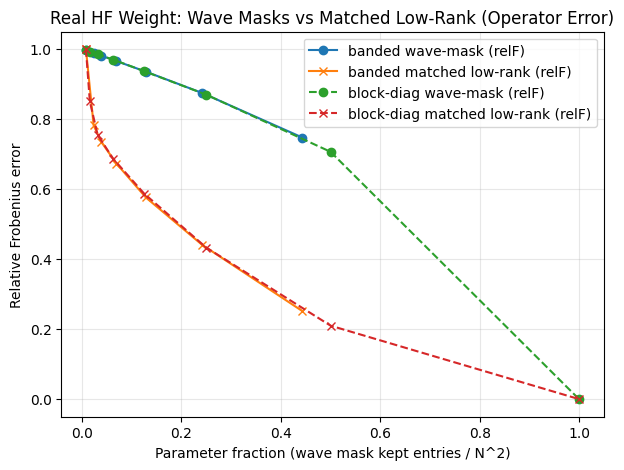

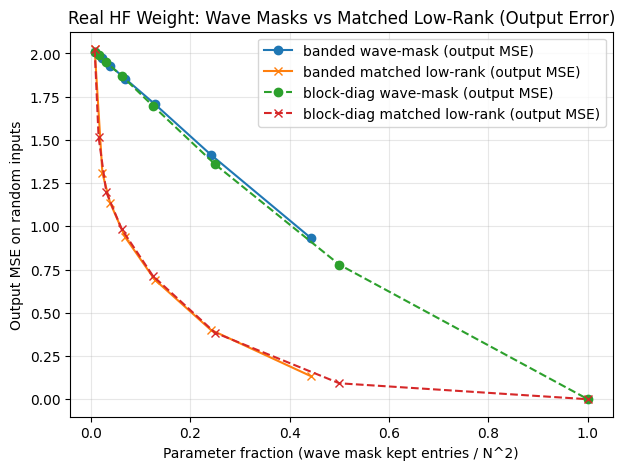

In [16]:
# Overlay plots: banded + block-diagonal wave-masks vs matched low-rank on the same axes.
# Uses arrays computed above:
#   wave_vs_lr_band  columns: [kfrac, wave_relF, wave_mse, r, lr_relF, lr_mse]
#   wave_vs_lr_block columns: [kfrac, wave_relF, wave_mse, r, lr_relF, lr_mse]

# Operator error overlay
plt.figure(figsize=(7, 5))
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 1], marker='o', label='banded wave-mask (relF)')
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 4], marker='x', label='banded matched low-rank (relF)')
plt.plot(wave_vs_lr_block[:, 0], wave_vs_lr_block[:, 1], marker='o', linestyle='--', label='block-diag wave-mask (relF)')
plt.plot(wave_vs_lr_block[:, 0], wave_vs_lr_block[:, 4], marker='x', linestyle='--', label='block-diag matched low-rank (relF)')
plt.xlabel('Parameter fraction (wave mask kept entries / N^2)')
plt.ylabel('Relative Frobenius error')
plt.title('Real HF Weight: Wave Masks vs Matched Low-Rank (Operator Error)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Output error overlay
plt.figure(figsize=(7, 5))
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 2], marker='o', label='banded wave-mask (output MSE)')
plt.plot(wave_vs_lr_band[:, 0], wave_vs_lr_band[:, 5], marker='x', label='banded matched low-rank (output MSE)')
plt.plot(wave_vs_lr_block[:, 0], wave_vs_lr_block[:, 2], marker='o', linestyle='--', label='block-diag wave-mask (output MSE)')
plt.plot(wave_vs_lr_block[:, 0], wave_vs_lr_block[:, 5], marker='x', linestyle='--', label='block-diag matched low-rank (output MSE)')
plt.xlabel('Parameter fraction (wave mask kept entries / N^2)')
plt.ylabel('Output MSE on random inputs')
plt.title('Real HF Weight: Wave Masks vs Matched Low-Rank (Output Error)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 8.3. Interpretation

- As capacity increases (more wave-domain entries kept), approximation error should monotonically decrease.
- **Diagonal** is the extreme low-capacity case.
- **Banded** tends to add capacity “near” the diagonal first (often a good bias if the basis captures locality of interactions).
- **Block-diagonal** adds capacity in chunks; it can be useful if interactions cluster into independent subsystems.

In real model work, you’d choose the structure based on observed wave-domain patterns (e.g., a narrow band + occasional low-rank corrections) and then fine-tune under that constraint.